In [ ]:
import pandas as pd

# Use the correct filename (check spaces and underscores)
file_path = r"C:\LAB_TASKS\Data_Science\project\Womens Clothing Reviews.csv"  # Corrected name
df = pd.read_csv(file_path)

# Check if the data loaded correctly
print(df.info())


In [ ]:
# Handle missing values (if any still exist)
df.dropna(inplace=True)

# Verify if any missing values remain
print(df.isnull().sum())


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK datasets (only needed once)
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str) or text.strip() == "":  # Handle None or empty strings
        return ""
    
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Lemmatization & remove stopwords
    
    return text


In [ ]:
import pandas as pd

df = pd.read_csv("C:\LAB_TASKS\Data_Science\project\Womens Clothing Reviews.csv")  # Replace with your actual file path
print(df.head())  # Verify it's loaded

# List of selected columns
selected_columns = [
    "Clothing ID", "Age", "Title", "Rating", 
    "Recommended IND", "Positive Feedback Count", 
    "Division Name", "Department Name", "Class Name"
]

# Get unique counts for selected columns
unique_counts = df[selected_columns].nunique()

# Display results
print("🔹 Total Unique Values for Selected Columns:\n")
for col, count in unique_counts.items():
    print(f"{col}: {count}")


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure the text column is preprocessed
df['Title'] = df['Title'].fillna("").apply(preprocess_text)  # Fill missing & preprocess

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Apply TF-IDF transformation to the 'Title' column
X = tfidf.fit_transform(df['Title']).toarray()

# Define the target variable (Sentiment)
y = df['Rating'].apply(lambda x: 1 if x > 3 else 0)  # 1 = Positive, 0 = Negative


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000)  # Increased iterations to avoid convergence warnings
lr_model.fit(X_train, y_train)

# Support Vector Machine Model (Linear Kernel for efficiency)
svm_model = SVC(kernel='linear')  # Linear kernel speeds up training for text classification
svm_model.fit(X_train, y_train)

# Random Forest Model (Explicitly setting number of trees)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Logistic Regression Evaluation
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# Support Vector Machine Evaluation
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

# Random Forest Evaluation
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for Age
plt.figure(figsize=(12, 5))
sns.boxplot(x=df['Age'])
plt.title("Boxplot of Age (Detecting Outliers)")
plt.show()

# Boxplot for Ratings
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Rating'])
plt.title("Boxplot of Ratings (Detecting Outliers)")
plt.show()


In [ ]:
import numpy as np

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # 25th percentile
    Q3 = df[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_cleaned

# Apply to Age
df = remove_outliers(df, "Age")

# Ratings are between 1-5, so no need to remove unless there are incorrect values
df = df[(df['Rating'] >= 1) & (df['Rating'] <= 5)]


In [ ]:
from scipy.stats.mstats import winsorize

df["Age"] = winsorize(df["Age"], limits=[0.05, 0.05])  # Caps lowest 5% and highest 5%


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Define words commonly used in positive and negative reviews
positive_words = {"good", "great", "love", "amazing", "perfect", "beautiful", "cute", "best", "comfortable"}
negative_words = {"bad", "poor", "worst", "disappointed", "uncomfortable", "cheap", "not", "wrong", "issues"}

# Function to remove sentiment-related words from word clouds
def clean_text_for_wordcloud(text, remove_words):
    words = text.split()
    filtered_words = [word for word in words if word not in remove_words]
    return " ".join(filtered_words)

# Process text for word clouds
positive_reviews = df[y == 1]['Title'].dropna().apply(lambda x: clean_text_for_wordcloud(x, negative_words))
negative_reviews = df[y == 0]['Title'].dropna().apply(lambda x: clean_text_for_wordcloud(x, positive_words))

# Generate word clouds with max_words to balance word usage
positive_wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=100).generate(" ".join(positive_reviews))
negative_wordcloud = WordCloud(width=800, height=400, background_color="black", max_words=100).generate(" ".join(negative_reviews))

# Plot Word Clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Generate predictions for each model
y_pred_lr = lr_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Plot Confusion Matrix for Logistic Regression
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Plot Confusion Matrix for SVM
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)
plt.title('SVM Confusion Matrix')
plt.show()

# Plot Confusion Matrix for Random Forest
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title('Random Forest Confusion Matrix')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette=["red", "green"])
plt.title("Sentiment Distribution (Positive vs. Negative Reviews)")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Review Count")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.show()


In [ ]:
plt.figure(figsize=(7, 5))
sns.histplot(df["Rating"], bins=5, kde=True, color="blue")
plt.title("Distribution of Ratings")
plt.xlabel("Ratings (1-5)")
plt.ylabel("Count")
plt.show()


In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Handle negations
negation_words = {"not", "no", "never", "isn't", "wasn't", "don't", "doesn't"}

def preprocess_text(text):
    if isinstance(text, str):  
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        words = text.split()
        
        processed_words = []
        i = 0
        while i < len(words):
            if words[i] in negation_words and i + 1 < len(words):
                # Combine negation with the next word
                processed_words.append(words[i] + "_" + words[i + 1])  
                i += 1  # Skip next word since it's combined
            else:
                processed_words.append(words[i])
            i += 1
        
        text = ' '.join([lemmatizer.lemmatize(word) for word in processed_words if word not in stop_words])
    return text

# Apply preprocessing
df['cleaned_review'] = df['Title'].apply(preprocess_text)  


In [ ]:
from wordcloud import WordCloud

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=100).generate(" ".join(df[y == 1]['Title'].dropna()))
negative_wordcloud = WordCloud(width=800, height=400, background_color="black", max_words=100).generate(" ".join(df[y == 0]['Title'].dropna()))

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(y=df["Department Name"], order=df["Department Name"].value_counts().index, palette="coolwarm")
plt.title("Most Reviewed Departments")
plt.xlabel("Review Count")
plt.ylabel("Department Name")
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(y=df.groupby("Department Name")["Rating"].mean().index, x=df.groupby("Department Name")["Rating"].mean().values, palette="coolwarm")
plt.title("Average Rating per Department")
plt.xlabel("Average Rating")
plt.ylabel("Department Name")
plt.show()



In [ ]:
plt.figure(figsize=(10, 5))
top_products = df["Clothing ID"].value_counts().head(10)
sns.barplot(y=top_products.index, x=top_products.values, palette="viridis")
plt.title("Top 10 Most Reviewed Products")
plt.xlabel("Review Count")
plt.ylabel("Clothing ID")
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=df["Age"], y=df["Rating"], color="purple", marker="o")
plt.title("Rating Trends by Age")
plt.xlabel("Age")
plt.ylabel("Average Rating")
plt.show()


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=axes[0])
axes[0].set_title('Logistic Regression')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, ax=axes[1])
axes[1].set_title('SVM')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=axes[2])
axes[2].set_title('Random Forest')

plt.show()


In [ ]:
# Splitting the dataset into positive and negative reviews
df_positive = df[df['Rating'] > 3]  # Ratings 4 & 5
df_negative = df[df['Rating'] <= 3]  # Ratings 3, 2, 1


In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette=["red", "green"])
plt.title("Sentiment Distribution (Positive vs. Negative Reviews)")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Review Count")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get the most common 10 departments in positive and negative reviews separately
top_positive = df_positive["Department Name"].value_counts().nlargest(10)
top_negative = df_negative["Department Name"].value_counts().nlargest(10)

# Get only the departments that exist in both lists
common_departments = list(set(top_positive.index) & set(top_negative.index))[:10]  # Ensure max 10 categories

# Filter positive & negative reviews for only the common departments
top_positive = top_positive.loc[common_departments]
top_negative = top_negative.loc[common_departments]

# Create a combined DataFrame
df_top_departments = pd.DataFrame({
    "Department Name": common_departments * 2,
    "Review Count": list(top_positive) + list(top_negative),
    "Sentiment": ["Positive"] * len(top_positive) + ["Negative"] * len(top_negative)
})

plt.figure(figsize=(12, 6))

# Plot positive & negative reviews together
sns.barplot(
    data=df_top_departments,
    y="Department Name",
    x="Review Count",
    hue="Sentiment",
    palette={"Positive": "green", "Negative": "red"}
)

plt.title("Top Reviewed Departments (Positive vs Negative)")
plt.xlabel("Review Count")
plt.ylabel("Department Name")
plt.legend(title="Sentiment")
plt.show()


In [ ]:
from wordcloud import WordCloud

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=100).generate(" ".join(df_positive['Title'].dropna()))
negative_wordcloud = WordCloud(width=800, height=400, background_color="black", max_words=100).generate(" ".join(df_negative['Title'].dropna()))

# Plot word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()


In [ ]:
plt.figure(figsize=(12, 5))

# Positive Ratings
plt.subplot(1, 2, 1)
sns.barplot(y=df_positive.groupby("Department Name")["Rating"].mean().index, 
            x=df_positive.groupby("Department Name")["Rating"].mean().values, 
            palette="Greens_r")
plt.title("Average Rating per Department (Positive Reviews)")
plt.xlabel("Average Rating")
plt.ylabel("Department Name")

# Negative Ratings
plt.subplot(1, 2, 2)
sns.barplot(y=df_negative.groupby("Department Name")["Rating"].mean().index, 
            x=df_negative.groupby("Department Name")["Rating"].mean().values, 
            palette="Reds_r")
plt.title("Average Rating per Department (Negative Reviews)")
plt.xlabel("Average Rating")
plt.ylabel("Department Name")

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(12, 5))

# Positive Ratings
plt.subplot(1, 2, 1)
sns.lineplot(x=df_positive["Age"], y=df_positive["Rating"], color="green", marker="o")
plt.title("Positive Ratings by Age")
plt.xlabel("Age")
plt.ylabel("Average Rating")

# Negative Ratings
plt.subplot(1, 2, 2)
sns.lineplot(x=df_negative["Age"], y=df_negative["Rating"], color="red", marker="o")
plt.title("Negative Ratings by Age")
plt.xlabel("Age")
plt.ylabel("Average Rating")

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(12, 5))

# Positive Reviews
plt.subplot(1, 2, 1)
top_positive_products = df_positive["Clothing ID"].value_counts().head(10)
sns.barplot(y=top_positive_products.index, x=top_positive_products.values, palette="Greens_r")
plt.title("Top 10 Most Reviewed Products (Positive)")
plt.xlabel("Review Count")
plt.ylabel("Clothing ID")

# Negative Reviews
plt.subplot(1, 2, 2)
top_negative_products = df_negative["Clothing ID"].value_counts().head(10)
sns.barplot(y=top_negative_products.index, x=top_negative_products.values, palette="Reds_r")
plt.title("Top 10 Most Reviewed Products (Negative)")
plt.xlabel("Review Count")
plt.ylabel("Clothing ID")

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(df_positive["Positive Feedback Count"], bins=20, kde=True, color="green", label="Positive Reviews")
sns.histplot(df_negative["Positive Feedback Count"], bins=20, kde=True, color="red", label="Negative Reviews")
plt.title("Positive Feedback Count (Positive vs. Negative Reviews)")
plt.xlabel("Positive Feedback Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
# Use the correct filename (check spaces and underscores)
file_path = r"C:\LAB_TASKS\Data_Science\project\Womens Clothing Reviews.csv"  # Corrected name
df = pd.read_csv(file_path)

C:\Users\Admin\AppData\Local\Temp\ipykernel_16368\1034010955.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


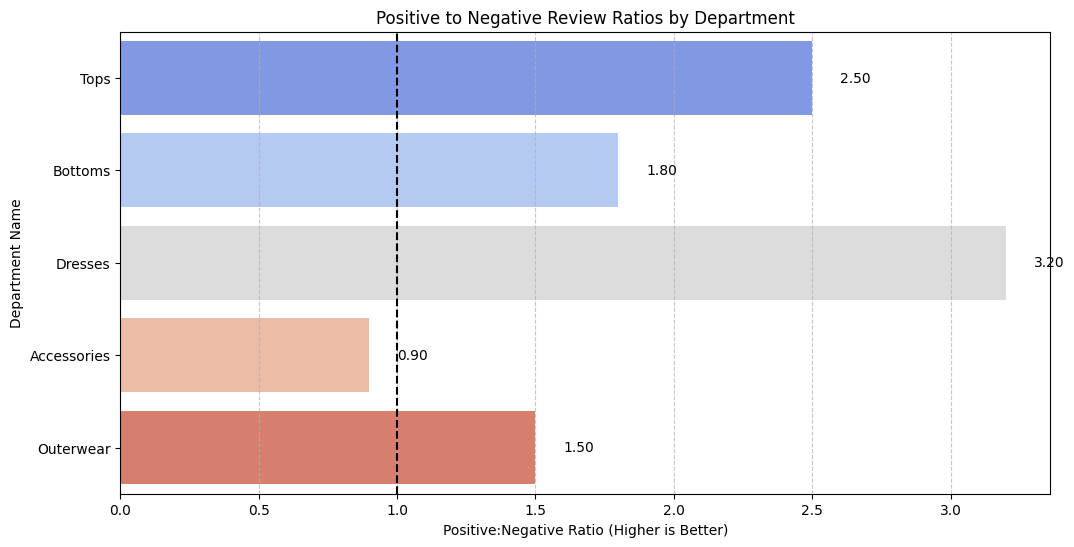

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define df_ratios
df_ratios = pd.DataFrame({
    "Department Name": ["Tops", "Bottoms", "Dresses", "Accessories", "Outerwear"],
    "Positive:Negative Ratio": [2.5, 1.8, 3.2, 0.9, 1.5]  # Example ratios
})

# Visualization: Highlight departments with high negative review impact
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_ratios,
    x="Positive:Negative Ratio",
    y="Department Name",
    palette="coolwarm"
)

plt.axvline(x=1, color="black", linestyle="--", linewidth=1.5)  # Reference line at ratio = 1
plt.grid(axis="x", linestyle="--", alpha=0.7)  # Grid lines for better readability
plt.title("Positive to Negative Review Ratios by Department")
plt.xlabel("Positive:Negative Ratio (Higher is Better)")
plt.ylabel("Department Name")

# Add value labels to bars
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.2f}', (width + 0.1, p.get_y() + p.get_height() / 2), ha="left", va="center", fontsize=10)

plt.show()